In [40]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler



# pvlib imports
import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


In [16]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Papers/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting'

In [29]:
df_meta = pd.read_csv("../../Input_Data/Meta_Data_PV_Optimised.csv", index_col = 0)

In [20]:
# model clear sky for all systems

df_meteo = pd.read_csv("../../Input_Data/ghi_dni_dhi.csv", index_col=0, parse_dates=True)
print(df_meteo.shape)
print(df_meteo.columns)
df_meteo = df_meteo.drop_duplicates() #we only need independent samples of the meteo data
print(df_meteo.shape)

(105692, 3)
Index(['dhi', 'dni', 'ghi'], dtype='object')
(27741, 3)


In [30]:
df_meta

,tilt_finetuned,azimuth_finetuned
281,14,220
195,15,186
152,61,201
207,12,185
154,14,224
175,21,223
384,64,223
389,6,158
444,17,208
188,11,233


# Data Prep

In [21]:

latitude = 52.0878 
longitude =  5.16622
location_meteo = Location(latitude=latitude, longitude=longitude)

In [22]:
def physical_profile(row):
    index, latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(surface_tilt= tilt , surface_azimuth=azimuth,
        module_parameters={'pdc0': capacity, 'gamma_pdc': -0.004},
        inverter_parameters={'pdc0': capacity},
        temperature_model_parameters=temperature_model_parameters)
    
    mc = ModelChain(pvwatts_system, location, aoi_model='physical', spectral_model='no_loss')
    mc.run_model(df_meteo)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"

    return df_results



In [23]:
import itertools
tilt_azimuth_combinations = list(itertools.product(range(0,91,1), range(0,361,1)))

In [34]:
tilt_azi_np_array = np.array(tilt_azimuth_combinations)

tilt_azi_np_array = df_meta.values

tilt_azi_np_array.shape

(34, 2)

In [35]:
df_meta_con = pd.DataFrame({"lat": latitude, "lon": longitude, "tilt":0, "azimuth": 0, "capacity":1}, index = range(tilt_azi_np_array.shape[0]))

In [36]:
df_meta_con[["tilt", "azimuth"]] = tilt_azi_np_array

In [37]:
df_meta_con = df_meta_con.reset_index()

In [38]:
df_meta_con

,index,lat,lon,tilt,azimuth,capacity
0,0,52.0878,5.16622,14,220,1
1,1,52.0878,5.16622,15,186,1
2,2,52.0878,5.16622,61,201,1
3,3,52.0878,5.16622,12,185,1
4,4,52.0878,5.16622,14,224,1
5,5,52.0878,5.16622,21,223,1
6,6,52.0878,5.16622,64,223,1
7,7,52.0878,5.16622,6,158,1
8,8,52.0878,5.16622,17,208,1
9,9,52.0878,5.16622,11,233,1


In [39]:
df_physical = df_meta_con.apply(physical_profile, axis = 1)

In [42]:
df_physical_T = df_physical.T

In [43]:

arrays = []

for col in df_physical_T:
    df_col = df_physical_T[[col]]
    df_col["tilt"] = df_meta_con.iloc[col,:]["tilt"]
    df_col["azimuth"] = df_meta_con.iloc[col,:]["azimuth"]
    df_col["dhi"] = df_meteo["dhi"]
    df_col["dni"] = df_meteo["dni"]
    df_col["ghi"] = df_meteo["ghi"]
    array = df_col.to_numpy()
    arrays.append(array)


arrays_stacked = np.stack(arrays)
x,y,z = arrays_stacked.shape
arrays_stacked_reshaped = arrays_stacked.reshape(1,x*y, z)


<ipython-input-43-c20377a4c9f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col["tilt"] = df_meta_con.iloc[col,:]["tilt"]
<ipython-input-43-c20377a4c9f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col["azimuth"] = df_meta_con.iloc[col,:]["azimuth"]
<ipython-input-43-c20377a4c9f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [44]:

samples = arrays_stacked_reshaped.squeeze()


In [45]:
df_samples = pd.DataFrame(samples ,columns=["power", "tilt", "azimuth", "dhi", "dni", "ghi"])

In [47]:
df_samples.to_parquet("../../Input_Data/inverse_samples.parquet")

# Modelling

### Data Read-In

In [48]:
df_samples = pd.read_parquet("../../Input_Data/inverse_samples.parquet")
scaler2 = MinMaxScaler()
df_samples[df_samples.columns] = scaler2.fit_transform(df_samples[df_samples.columns])


### Training A Neural Network with Pytorch

In [376]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.nn as nn


In [313]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NameError: name 'MinMaxScaler' is not defined

In [408]:
x_numpy = df_samples.iloc[:,:3].to_numpy()
y_numpy = df_samples.iloc[:,3:].to_numpy()

In [409]:
x_tensor = torch.from_numpy(x_numpy).float()
y_tensor = torch.from_numpy(y_numpy).float()

In [410]:
m , n = x_tensor.shape
m

train_len = round(m*0.8)
val_len = round(m*0.2)


assert train_len + val_len == m


In [411]:
dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [train_len, val_len] )

In [413]:
train_loader = DataLoader(dataset=train_dataset, batch_size=20)
val_loader = DataLoader(dataset=val_dataset, batch_size=30)

In [414]:
def make_train_step(model, loss_fn, optimizer): # this is a useful closure for the train step
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    return train_step

In [415]:
model = nn.Sequential(
    nn.Linear(3,3),

)

In [416]:

lr = 1e-1

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr = lr)

train_step = make_train_step(model, loss_fn, optimizer)

In [417]:
losses = []
val_losses = []

n_epochs = 10

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch,y_batch)
        losses.append(loss)

    with torch.no_grad():

        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

KeyboardInterrupt: 

<AxesSubplot:>

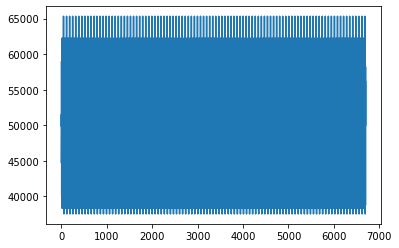

In [354]:
pd.Series(np.array(val_losses)).plot()

### XGBoost

In [49]:



from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(df_samples.iloc[:,:3], df_samples.iloc[:,-1:], test_size = 0.2)



In [50]:
from xgboost import XGBRegressor

In [53]:
from sklearn.model_selection import cross_validate, GridSearchCV, TimeSeriesSplit

model = XGBRegressor()

#the two most important parameters for XGBoost. 
param_grid = {
                'eta':[0.2, 0.3, 0.4, 0.5], 
                'max_depth': [1,2,4,8] 
            }

cv = TimeSeriesSplit(4, gap = 1)
gs = GridSearchCV(model, param_grid, cv=cv, scoring = "neg_root_mean_squared_error").fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
best_model = gs.best_estimator_

best_model.fit(X_train,y_train)
predictions = best_model.predict(X_test)

test_compare = y_test.copy().iloc[:,:1]
test_compare["predictions"] = predictions

In [402]:
y_test["predictions"] = model.predict(X_test)

In [406]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test.iloc[:,:1], y_test.iloc[:,1:], squared=False)

0.16362683731524102